In [2]:
RACK_MAX = 7
FV_WEIGHT_NUM = 26

import random
import os
import numpy as np
import matplotlib.pyplot as plt 

import scrabbler as sc
from scrabbler.dictionary import Dictionary
import utilities.logger as logger

RACK_MAX = 7

LETTER_VALUE = {}
with open("resources/scrabble/tile_list.txt") as f:
    for line in f:
        (key, val) = line.split()
        LETTER_VALUE[key] = int(val)


cwd = os.getcwd()
resource_dir = os.path.join(cwd, "resources")
resource_directory = os.path.join(resource_dir, "scrabble")
saved_dictionary_path = os.path.join(resource_directory, "dictionary.p")

In [3]:
logger.info("loading saved dictionary file...")
global_dictionary = Dictionary.load_from_pickle(saved_dictionary_path)
bag_o = ["A", "A", "A", "A", "A", "A", "A", "A", "A",
         "B", "B",
         "C", "C",
         "D", "D", "D", "D",
         "E", "E", "E", "E", "E", "E", "E", "E", "E", "E", "E", "E",
         "F", "F",
         "G", "G", "G",
         "H", "H",
         "I", "I", "I", "I", "I", "I", "I", "I", "I",
         "J",
         "K",
         "L", "L", "L", "L",
         "M", "M",
         "N", "N", "N", "N", "N", "N",
         "O", "O", "O", "O", "O", "O", "O", "O",
         "P", "P",
         "Q",
         "R", "R", "R", "R", "R", "R",
         "S", "S", "S", "S",
         "T", "T", "T", "T", "T", "T",
         "U", "U", "U", "U",
         "V", "V",
         "W", "W",
         "X",
         "Y", "Y",
         "Z"]




2023-05-08 17:26:59 INFO: loading saved dictionary file...


In [4]:
def vectorize( rack):
    # First, place the (simplified) board state into the feature vector:
    # vec = []
    # for i in range(15):
    #     for j in range(15):
    #         if board.square(i, j)._tile:
    #             vec.append(ord(board.square(i, j)._tile))
    #             print(ord((board.square(i, j)._tile)))
    #         else:
    #             vec.append(0)
    # Next, place the entirety of the rack into the feature vector:
    # for i in range(RACK_MAX):
    #     vec.append(ord(rack[i]))

    # vec.append(score1)
    # vec.append(score2)
    # return vec
    vectorized_leave = [0]*26 # Our vectorized version of the leaves which we will update to represent the leaves below
    for letter in rack:
        index = ord(letter) - 65
        vectorized_leave[index] += 1

    return vectorized_leave 

In [5]:
def choose_move(moves, game=None, bag=None, played=None):
    # start by running an episode for the first move:
    eps = 0.75
    r = random.uniform(0, 1)
    if r <= eps:
        move = random.choice(moves)
    else:
        # the parameterized policy will select the move, given the state (board, bag, played, etc.)
        move = moves[0]

    return move

In [6]:
def remove_specific_letters(arr, letters_to_remove):
    return [string for string in arr if not any(letter in string for letter in letters_to_remove)]


In [7]:
def sliding_window(data, window_size):
    arr = []
    for i in range(window_size, len(data)):
        arr.append(np.average(data[i - window_size:i]))

    return arr 


In [8]:
weights = np.random.rand(FV_WEIGHT_NUM, 1)
diff = []
STEP_SIZE = 1e-5

for i in range(1500):
    print("iter:",i)
    bag = bag_o.copy()
    random.shuffle(bag)
    score1 = 0  # resetting the scores and bag:
    score2 = 0
    game = sc.Game(filename="/Users/sbrosh1/Documents/GitHub/scrabbler/games/start_state.p",
                            global_dictionary=global_dictionary, enable_logger=False)
    rack1 = []
    rack2 = []
    for i in range(RACK_MAX):
        rack1.append(bag.pop())
        rack2.append(bag.pop())

    moves = game.find_best_moves(rack1, num = 20)
    if moves:
        move = choose_move(moves)
        game.play(move.start_square, move.word, move.direction)
        score1 = score1 + move.score

        rack1 = remove_specific_letters(rack1, move.word)


        # Get feature vector using vectorize function, an approximate the value function.
        approx_vf = np.dot(vectorize(rack1), weights)
            
        # Draw the number of letters played:
        for l in range(len(move.word)):
            rack1.append(bag.pop())

    # If unable to play a move:
    # else:
    #     for l in range(len(rack1)):
    #         if LETTER_VALUE[rack1[l]] > 4:
    #             bag.append(rack1[l])
    #             random.shuffle(bag)
    #             rack1 = rack1.replace(rack1[l], bag.pop(), 1)
        

    moves = game.find_best_moves(rack2, num = 1)
    if moves:
        game.play(moves[0].start_square, moves[0].word, moves[0].direction)
        score2 = score2 + moves[0].score

        rack2 = remove_specific_letters(rack2, moves[0].word)
        for l in range(len(moves[0].word)):
            rack2.append(bag.pop())

        # for i in range(len(moves[0].word)):                    
        #     if len(bag) > 0:
        #         rack2 = rack2.replace(moves[0].word[i], bag.pop(), 1)
        #     else:
        #         rack2 = rack2.replace(moves[0].word[i], '', 1)

    # else:
    #     for l in range(len(rack2)):
    #         if LETTER_VALUE[rack2[l]] > 4:
    #             bag.append(rack2[l])
    #             random.shuffle(bag)
    #             rack2 = rack2.replace(rack2[l], bag.pop(), 1)



    # Now, play the next move, and see what the effect of leaving those above tiles has on the scores:

    moves = game.find_best_moves(rack1, num = 1)
    if moves:
        move = choose_move(moves)
        game.play(move.start_square, move.word, move.direction)
        score1 = score1 + move.score
        term1 = move.score
        rack1 = remove_specific_letters(rack1, move.word)
        # Draw the number of letters played:
        for l in range(len(move.word)):
            rack1.append(bag.pop())
        # for i in range(len(moves[0].word)):                    
        #     if len(bag) > 0:
        #         rack1 = rack1.replace(moves[0].word[i], bag.pop(), 1)
        #     else:
        #         rack1 = rack1.replace(moves[0].word[i], '', 1)

    # If unable to play a move:
    else:
        for l in range(len(rack1)):
            if LETTER_VALUE[rack1[l]] > 4:
                bag.append(rack1[l])
                random.shuffle(bag)
                rack1 = rack1.replace(rack1[l], bag.pop(), 1)


    # Player 2 plays:
    moves = game.find_best_moves(rack2, num = 0)
    if moves:
        game.play(moves[0].start_square, moves[0].word, moves[0].direction)
        score2 = score2 + moves[0].score
        term2 = moves[0].score 
        rack2 = remove_specific_letters(rack2, moves[0].word)
        for l in range(len(moves[0].word)):
            rack2.append(bag.pop())

        # for i in range(len(moves[0].word)):                    
        #     if len(bag) > 0:
        #         rack2 = rack2.replace(moves[0].word[i], bag.pop(), 1)
        #     else:
        #         rack2 = rack2.replace(moves[0].word[i], '', 1)

    # else:
    #     for l in range(len(rack2)):
    #         if LETTER_VALUE[rack2[l]] > 4:
    #             bag.append(rack2[l])
    #             random.shuffle(bag)
    #             rack2 = rack2.replace(rack2[l], bag.pop(), 1)


    # Now, we need to calculate the true value function:
    # We do this by subtracting the scores from the second play above.
    # By computing the evaluation function this way, the aim is to see if there is a pattern between leaving certain letters, 
    # and scoring a higher score in the next move.
    true_vf = term1


    diff.append(true_vf - approx_vf)
    
    delw = STEP_SIZE * (true_vf - approx_vf) * weights 
    weights = weights + delw # Not experiencing exploding or vanishing gradients after 1500 iterations.

    print(np.abs(true_vf - approx_vf))

# np.save(weights)
print(weights)



iter: 0
[0.75622396]
iter: 1
[35.67678119]
iter: 2
[34.43772986]
iter: 3
[15.67796126]
iter: 4
[60.24843118]
iter: 5
[4.21955093]
iter: 6
[18.52653176]
iter: 7
[6.55618525]
iter: 8
[32.43403626]
iter: 9
[7.82306233]
iter: 10
[38.46355149]
iter: 11
[2.13929887]
iter: 12
[4.46131539]
iter: 13
[4.11444087]
iter: 14
[7.03439563]
iter: 15
[19.]
iter: 16
[17.84002723]
iter: 17
[5.89219371]
iter: 18
[25.07511651]
iter: 19
[27.38391075]
iter: 20
[8.21368408]
iter: 21
[8.91212492]
iter: 22
[7.94754964]
iter: 23
[6.46058302]
iter: 24
[6.67021523]
iter: 25
[9.24602705]
iter: 26
[20.22276529]
iter: 27
[1.997386]
iter: 28
[4.8095749]
iter: 29
[64.07136418]
iter: 30
[37.50333949]
iter: 31
[0.80952138]
iter: 32
[5.75611994]
iter: 33
[5.]
iter: 34
[2.16907726]
iter: 35
[62.14981933]
iter: 36
[10.]
iter: 37
[12.05374256]
iter: 38
[7.40760345]
iter: 39
[35.65409139]
iter: 40
[3.42466625]
iter: 41
[4.36988767]
iter: 42
[6.10629431]
iter: 43
[19.91382032]
iter: 44
[39.20267035]
iter: 45
[11.63470751]
iter

(1450,)


Text(0.5, 1.0, 'Moving average of loss |true VF - approx VF|')

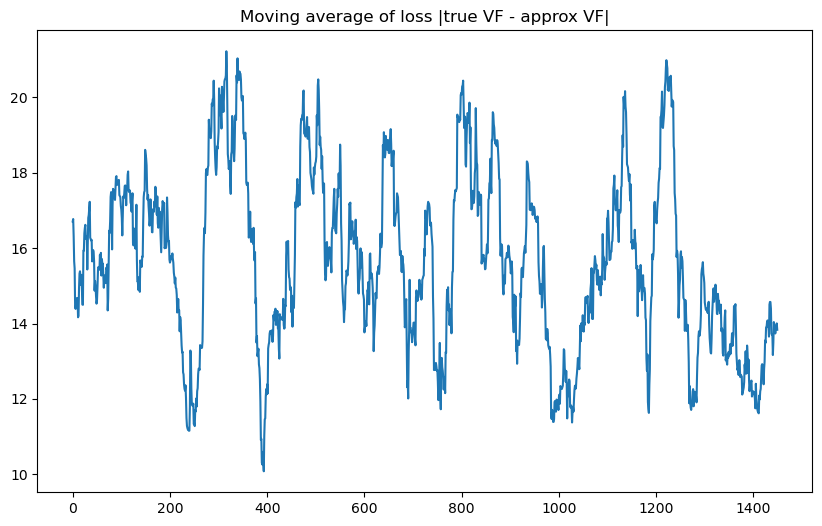

In [9]:
# Compute the moving average with window length 50
window_length = 50
moving_average = sliding_window(np.abs(diff), window_length)

print(np.shape(moving_average))

fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(moving_average, label = "Moving Average")

ax.set_title("Moving average of loss |true VF - approx VF|")


In [1]:
# Compute the moving average with window length 50
window_length = 50
moving_average = sliding_window(np.abs(diff), window_length)

print(np.shape(moving_average))

fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(moving_average, label = "Moving Average")

ax.set_title("Moving average of loss |true VF - approx VF|")

NameError: name 'sliding_window' is not defined